In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from matplotlib.colors import ListedColormap
df = pd.read_csv('pima-indians-diabetes.csv', encoding='utf-8')
# I ran print(df.duplicated().sum()) to find if there were any duplicates... but there isn't
columns = ['Preg', 'Plas', 'Pres', 'skin', 'test', 'mass']
val = []
# finding number of zeros in each column
#if for example I had a 0 value in skin column, it wouldn't make any sense
for column in columns:
      val.append(len(df[df[column] == 0]))
zeros = pd.DataFrame(val, index = columns, columns = ['zeros'])
print(zeros)
#replacing zero values with mean value
for column in columns:
    df[column] = df[column].replace(0,np.NaN)
    mean = int(df[column].mean(skipna = True))
    df[column] = df[column].replace(np.NaN, mean)
df.describe()

      zeros
Preg    111
Plas      5
Pres     35
skin    227
test    374
mass     11


,Preg,Plas,Pres,skin,test,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.000000,768.000000
mean,4.423177,121.682292,72.386719,29.108073,155.28125,32.450911,0.471876,33.240885,0.348958
std,2.980481,30.435999,12.096642,8.791221,85.02155,6.875366,0.331329,11.760232,0.476951
min,1.000000,44.000000,24.000000,7.000000,14.00000,18.200000,0.078000,21.000000,0.000000
25%,2.000000,99.750000,64.000000,25.000000,121.50000,27.500000,0.243750,24.000000,0.000000
50%,4.000000,117.000000,72.000000,29.000000,155.00000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.00000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.00000,67.100000,2.420000,81.000000,1.000000


Outliers Detection

<AxesSubplot:>

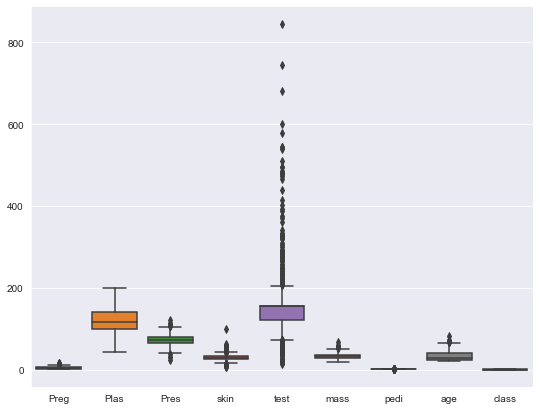

In [12]:
plt.figure(figsize=(9,7))
sns.boxplot(data=df)

Finding if there is a correlation between 'test' and 'class' columns

<AxesSubplot:xlabel='class', ylabel='test'>

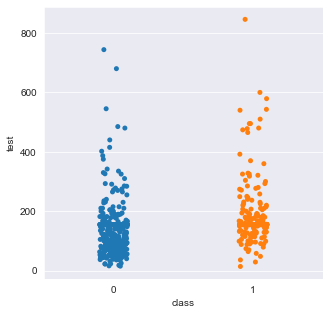

In [13]:
plt.figure(figsize = (5, 5))
sns.stripplot(y = 'test', data = df, x = 'class')

Detecting and removing outliers using z-score

In [14]:
from scipy import stats
z = np.abs(stats.zscore(df['test']))

In [15]:
threshold = 3
# getting the positions of the outliers and dropping the corresponding records
i = np.where(z > 3)
df.drop(index = i[0], inplace = True)
# printing count of total records after dropping outliers
print(df.shape[0])


749


Splitting the dataset (60% training, 20% validation, 20% testing)

In [16]:
x = df[['Preg', 'Plas', 'Pres', 'skin', 'test', 'mass', 'pedi', 'age']]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2022)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,
                                                  random_state=2022) # 0.25 * 0.80 = 0.20


Feature selection

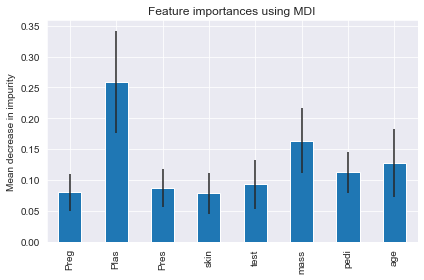

In [17]:
feature_names = ['Preg', 'Plas', 'Pres', 'skin', 'test', 'mass', 'pedi', 'age']
forest = RandomForestClassifier(random_state=2022)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Hence, the best 3 attributes are 'Plas', 'mass', 'age'

Finding the best K and printing the confusion matrix of each dataset for each k

In [18]:
neighbors = np.arange(1, 4)
accuracies_train = []
accuracies_val = []
accuracies_test = []
report_train = []
report_val = []
report_test = []
x_prime = df[['Plas', 'mass', 'age']]
X_prime_train, X_prime_test, y_prime_train, y_prime_test = train_test_split(x_prime, y, test_size=0.2, random_state=2022)
X_prime_train, X_prime_val, y_prime_train, y_prime_val = train_test_split(X_prime_train, y_prime_train, test_size=0.25,
                                                  random_state=2022)
# Loop over K values
for i, k in enumerate(neighbors):
    knn_train = KNeighborsClassifier(n_neighbors=k, metric = 'minkowski')
    knn_train.fit(X_prime_train, y_prime_train)
    y_predicted = knn_train.predict(X_prime_train)
    accuracy = metrics.accuracy_score(y_prime_train, y_predicted)
    accuracies_train.append(accuracy)
    report = metrics.classification_report(y_prime_train, y_predicted)
    report_train.append(report)
    print("Confusion matrix for k = " + str(i + 1) + " in training set" + "\t")
    print(metrics.confusion_matrix(y_prime_train, y_predicted))
    print("\n")

for i, k in enumerate(neighbors):
    knn_val = KNeighborsClassifier(n_neighbors=k, metric = 'minkowski')
    knn_val.fit(X_prime_train, y_prime_train)
    y_predicted = knn_val.predict(X_prime_val)
    accuracy = metrics.accuracy_score(y_prime_val, y_predicted)
    accuracies_val.append(accuracy)
    report = metrics.classification_report(y_prime_val, y_predicted)
    report_val.append(report)
    print("Confusion matrix for k = " + str(i + 1) + " in validation set" + "\t")
    print(metrics.confusion_matrix(y_prime_val, y_predicted))
    print("\n")

for i, k in enumerate(neighbors):
    knn_test = KNeighborsClassifier(n_neighbors=k, metric = 'minkowski')
    knn_test.fit(X_prime_train, y_prime_train)
    y_predicted = knn_test.predict(X_prime_test)
    accuracy = metrics.accuracy_score(y_prime_test, y_predicted)
    accuracies_test.append(accuracy)
    report = metrics.classification_report(y_prime_test, y_predicted)
    report_test.append(report)
    print("Confusion matrix for k = " + str(i + 1) + " in testing set" + "\t")
    print(metrics.confusion_matrix(y_prime_test, y_predicted))
    print("\n")
    
k_max_train = max((accuracies_train))
print(accuracies_train)
print("best k for TRAINING at index: " + str(accuracies_train.index(k_max_train)))
k_max_val = max((accuracies_val))
print(accuracies_val)
print("best k for VALIDATING at index: " + str(accuracies_val.index(k_max_val)))
k_max_test = max((accuracies_test))
print(accuracies_test)
print("best k for TESTING at index: " + str(accuracies_test.index(k_max_test)))

Confusion matrix for k = 1 in training set	
[[287   0]
 [  0 162]]


Confusion matrix for k = 2 in training set	
[[287   0]
 [ 77  85]]


Confusion matrix for k = 3 in training set	
[[257  30]
 [ 36 126]]


Confusion matrix for k = 1 in validation set	
[[72 24]
 [27 27]]


Confusion matrix for k = 2 in validation set	
[[86 10]
 [41 13]]


Confusion matrix for k = 3 in validation set	
[[72 24]
 [26 28]]


Confusion matrix for k = 1 in testing set	
[[79 31]
 [18 22]]


Confusion matrix for k = 2 in testing set	
[[98 12]
 [25 15]]


Confusion matrix for k = 3 in testing set	
[[83 27]
 [14 26]]


[1.0, 0.8285077951002228, 0.8530066815144766]
best k for TRAINING at index: 0
[0.66, 0.66, 0.6666666666666666]
best k for VALIDATING at index: 2
[0.6733333333333333, 0.7533333333333333, 0.7266666666666667]
best k for TESTING at index: 1


Printing classification report for each k of each dataset

In [19]:
print("Printing for each k the corresponding report of each data set")
for i in range(0, 3):
    print(report_train[i] + report_val[i] + report_test[i] )

Printing for each k the corresponding report of each data set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       287
           1       1.00      1.00      1.00       162

    accuracy                           1.00       449
   macro avg       1.00      1.00      1.00       449
weighted avg       1.00      1.00      1.00       449
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        96
           1       0.53      0.50      0.51        54

    accuracy                           0.66       150
   macro avg       0.63      0.62      0.63       150
weighted avg       0.66      0.66      0.66       150
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       110
           1       0.42      0.55      0.47        40

    accuracy                           0.67       150
   macro avg       0.61      0.63      0.62       150
weighted avg  

Plotting

C:\Users\Thanaa Jaradat\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


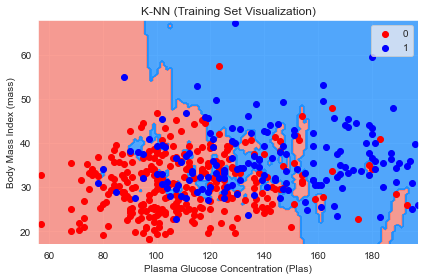

In [ ]:

X_s_df = X_prime_train[['Plas', 'mass']] 
y_s = y_prime_train
knn_plot_classifier = KNeighborsClassifier(n_neighbors=3)
knn_plot_classifier.fit(X_s_df, y_s)

# converting 2-feature dataframe to a numpy array 
X_s = X_s_df.values
X1, X2 = np.meshgrid(np.arange(start = X_s[:, 0].min() - 1, stop = X_s[:, 0].max() + 1, step = 1),
                     np.arange(start = X_s[:, 1].min() - 1, stop = X_s[:, 1].max() + 1, step = 0.5))

plt.contourf(X1, X2, knn_plot_classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('salmon', 'dodgerblue')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_s)):
    plt.scatter(X_s[y_s == j, 0], X_s[y_s == j, 1],
                color = ListedColormap(('red', 'blue'))(i), label = j)

plt.title('K-NN (Training Set Visualization)')
plt.xlabel('Plasma Glucose Concentration (Plas)')
plt.ylabel('Body Mass Index (mass)')
plt.legend()
plt.tight_layout()
plt.show()